In [1]:
import torch
from torch import nn
from torchinfo import summary
import matplotlib.pyplot as plt

from satforecast.data import data
from satforecast.modeling.data_selection import rolling_batch
from satforecast.modeling.data_selection import mean_and_std_of_files
from satforecast.modeling.train import train
from satforecast.modeling.model_selection import GridSearchNCV
from satforecast.data.viz import get_border_map

data.download()
image_dir = data.process_gs_rainfall_daily(scale=0.1)
image_files = data.get_files(image_dir, '*.npy')

## Model

In [2]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
    
    def __repr__(self):
        return f'Normalization(mean={self.mean}, std={self.std})'

    def forward(self, x):
        return (x - self.mean) / self.std

class RevNormalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std
    
    def __repr__(self):
        return f'RevNormalization(mean={self.mean}, std={self.std})'

    def forward(self, z):
        return z * self.std + self.mean

class CRNN(nn.Module):
    def __init__(
            self,
            image_size,
            in_channels,
            conv_channels,
            conv_kernel,
            pool_kernel,
            pool_stride,
            train_files = None,
            do_rev_norm = False
    ):
        super().__init__()
        self.conv_channels = conv_channels
        conv_padding = conv_kernel // 2
        
        self.do_norm = True if train_files is not None else False
        self.do_rev_norm = do_rev_norm
        if self.do_norm:
            mean, std = mean_and_std_of_files(train_files)
            self.norm = Normalization(mean, std)

        self.conv_in = nn.Conv2d(in_channels, conv_channels, conv_kernel, padding=conv_padding)
        self.pool = nn.MaxPool2d(pool_kernel, pool_stride)
        self.conv_cat = nn.Conv2d(2 * conv_channels, conv_channels, conv_kernel, padding=conv_padding)

        test_tensor = torch.empty(1, in_channels, image_size[0], image_size[1])
        test_tensor = self.conv_in(test_tensor)
        test_tensor = self.pool(test_tensor)
        test_tensor = torch.cat((test_tensor, torch.empty_like(test_tensor)), dim=1)
        test_tensor = self.conv_cat(test_tensor)
        self.pool_height, self.pool_width = test_tensor.shape[2:]
        #print(test_tensor.shape)

        conv_tpose_kernel = (image_size[0] - self.pool_height + 1,
                         image_size[1] - self.pool_width + 1)
        #print(conv_tpose_kernel)
        self.conv_tpose = nn.ConvTranspose2d(conv_channels, in_channels, conv_tpose_kernel)
        
        if self.do_rev_norm:
            self.rev_norm = RevNormalization(mean, std)
            
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.conv_channels, self.pool_height, self.pool_width)

    def conv_forward(self, x, h):
        # Consider 2 paths + connection here:
        # x -> conv -> pool -> cath
        # x -> cath* -> conv* -> pool
        #print(x.shape, h.shape)
        x = torch.tanh(self.conv_in(x))
        x = self.pool(x)
        h = torch.tanh(self.conv_cat(torch.cat((x, h), dim=1)))
        x = self.conv_tpose(h)
        return x, h

    def forward(self, x):
        
        seq_len = x.size(1)
        hidden = self.init_hidden(x.shape[0])
        
        if self.do_norm:
            x = self.norm(x)
        
        for step in range(seq_len - 1):
            _, hidden = self.conv_forward(x[:, step], hidden)
        
        pred, _ = self.conv_forward(x[:, -1], hidden)

        if self.do_rev_norm:
            pred = self.rev_norm(pred)

        return pred

    def predict(self, x):
        return self.forward(x)

# Debug Model
model = CRNN(image_size=(60, 180), in_channels=1, conv_channels=2, conv_kernel=5, pool_kernel=3, pool_stride=2)
model(torch.empty(2, 3, 1, 60, 180)).shape

torch.Size([2, 1, 60, 180])

## GridSearch configuration and hyperparameters

In [ ]:
%%time

# Data constants
DEV_N_IMAGES = 1_000
TRAIN_FRAC = 0.95
VAL_FRAC = 0.05
SEQ_LEN = 5
dev_image_files = image_files[:DEV_N_IMAGES]

# Training constants
BATCH_SIZE = 64
MAX_EPOCHS = 50
MIN_IMPROV = 0.001
MAX_ITER_IMPROV = 5

params = {
    'model__image_size': [(60, 180)],
    'model__in_channels': [1],
    'model__conv_channels': [2, 4],
    'model__conv_kernel': [15],
    'model__pool_kernel': [3, 5],
    'model__pool_stride': [1, 2, 3],
    #'model__do_norm': [True, False],
    #'model__do_rev_norm': [True, False],
    #'optimizer': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer': [torch.optim.AdamW],
    #'scheduler': [None, torch.optim.lr_scheduler.StepLR],
    #'scheduler__step_size': [2],
    'train__train_frac': [TRAIN_FRAC],
    'train__val_frac': [VAL_FRAC],
    'train__seq_len': [2, 5],
    'train__batch_size': [BATCH_SIZE],
    'train__max_epochs': [MAX_EPOCHS],
    #'train__val_level': ['batch', 'epoch'],
    'train__early_stopping': [True],
    'train__min_improv': [MIN_IMPROV],
    'train__max_iter_improv': [MAX_ITER_IMPROV],
    #'train__scheduler_level': ['batch', 'epoch'],
    #'train__shuffle': [True, False],
    'train__log_level': [3],
}

grid = GridSearchNCV(
    model_class = CRNN,
    name_base = 'crnn_v1',
    files_list = dev_image_files,
    param_grid = params,
    criterion = nn.MSELoss,
    nests_per_config = 1,
    log_level = 3
)
grid.fit()

[('crnn_v1__config_0', 0.028943361714482307),
 ('crnn_v1__config_1', 0.05889361724257469),
 ('crnn_v1__config_2', 0.045365478843450546),
 ('crnn_v1__config_3', 0.04352438449859619),
 ('crnn_v1__config_4', 0.04300086572766304),
 ('crnn_v1__config_5', 0.043386220932006836),
 ('crnn_v1__config_6', 0.02849840745329857),
 ('crnn_v1__config_7', 0.029862070456147194),
 ('crnn_v1__config_8', 0.045836783945560455),
 ('crnn_v1__config_9', 0.04361797496676445),
 ('crnn_v1__config_10', 0.042917050421237946),
 ('crnn_v1__config_11', 0.047688476741313934),
 ('crnn_v1__config_12', 0.027512913569808006),
 ('crnn_v1__config_13', 0.028122929856181145),
 ('crnn_v1__config_14', 0.041643090546131134),
 ('crnn_v1__config_15', 0.0412776842713356),
 ('crnn_v1__config_16', 0.04092215374112129),
 ('crnn_v1__config_17', 0.03878597915172577),
 ('crnn_v1__config_18', 0.028414065018296242),
 ('crnn_v1__config_19', 0.027156110852956772),
 ('crnn_v1__config_20', 0.04404349625110626),
 ('crnn_v1__config_21', 0.0411762

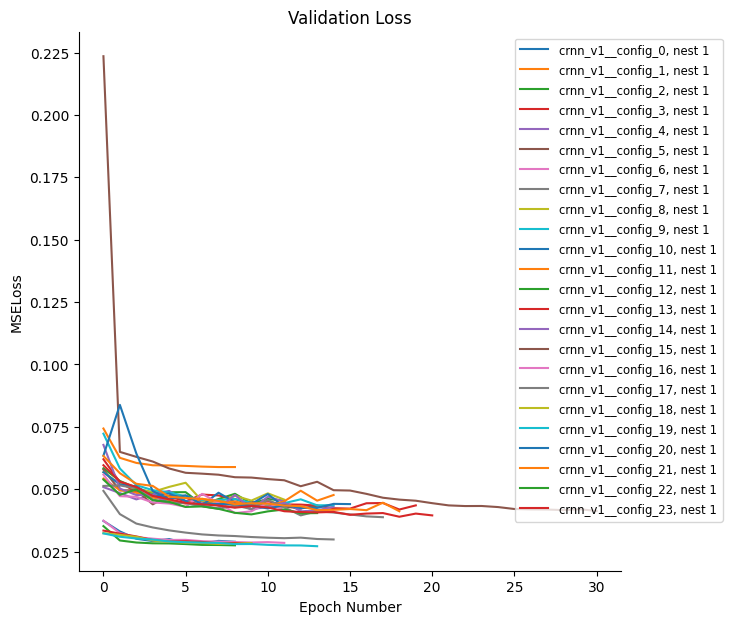

In [12]:
N_NESTS = 1
N_NESTS_TO_PLOT = 1
SUB_NEST_LINE_STYLES = ('dashed', 'dashdot', 'dotted')

fig, ax = plt.subplots(figsize=(7,7))

for config in grid.results:
    last_nest_line = plt.plot(
        grid.results[config][f'nest_{N_NESTS}']['val_loss'],
        linestyle='solid',
        label=f'{config}, nest {N_NESTS}'
    )
    color = last_nest_line[0].get_color()

    for prev_nest in range(1, N_NESTS_TO_PLOT):
        nest_n = N_NESTS - prev_nest
        plt.plot(
            grid.results[config][f'nest_{nest_n}']['val_loss'],
            linestyle=SUB_NEST_LINE_STYLES[prev_nest -1 ],
            label=f'{config}, nest {nest_n}',
            color=color
        )

legend = plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('MSELoss')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust the text size of the legend
font_props = {'size': 'small'}
plt.setp(legend.texts, **font_props)

from pprint import pprint
pprint([(config, grid.results[config]['mean_final_val_loss']) for config in grid.results])
print(f'Best config: {grid.best_config}')

## Predictions for best configuration

Layer (type:depth-idx)                   Param #
CRNN                                     --
├─Conv2d: 1-1                            904
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            7,204
├─ConvTranspose2d: 1-4                   101
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0


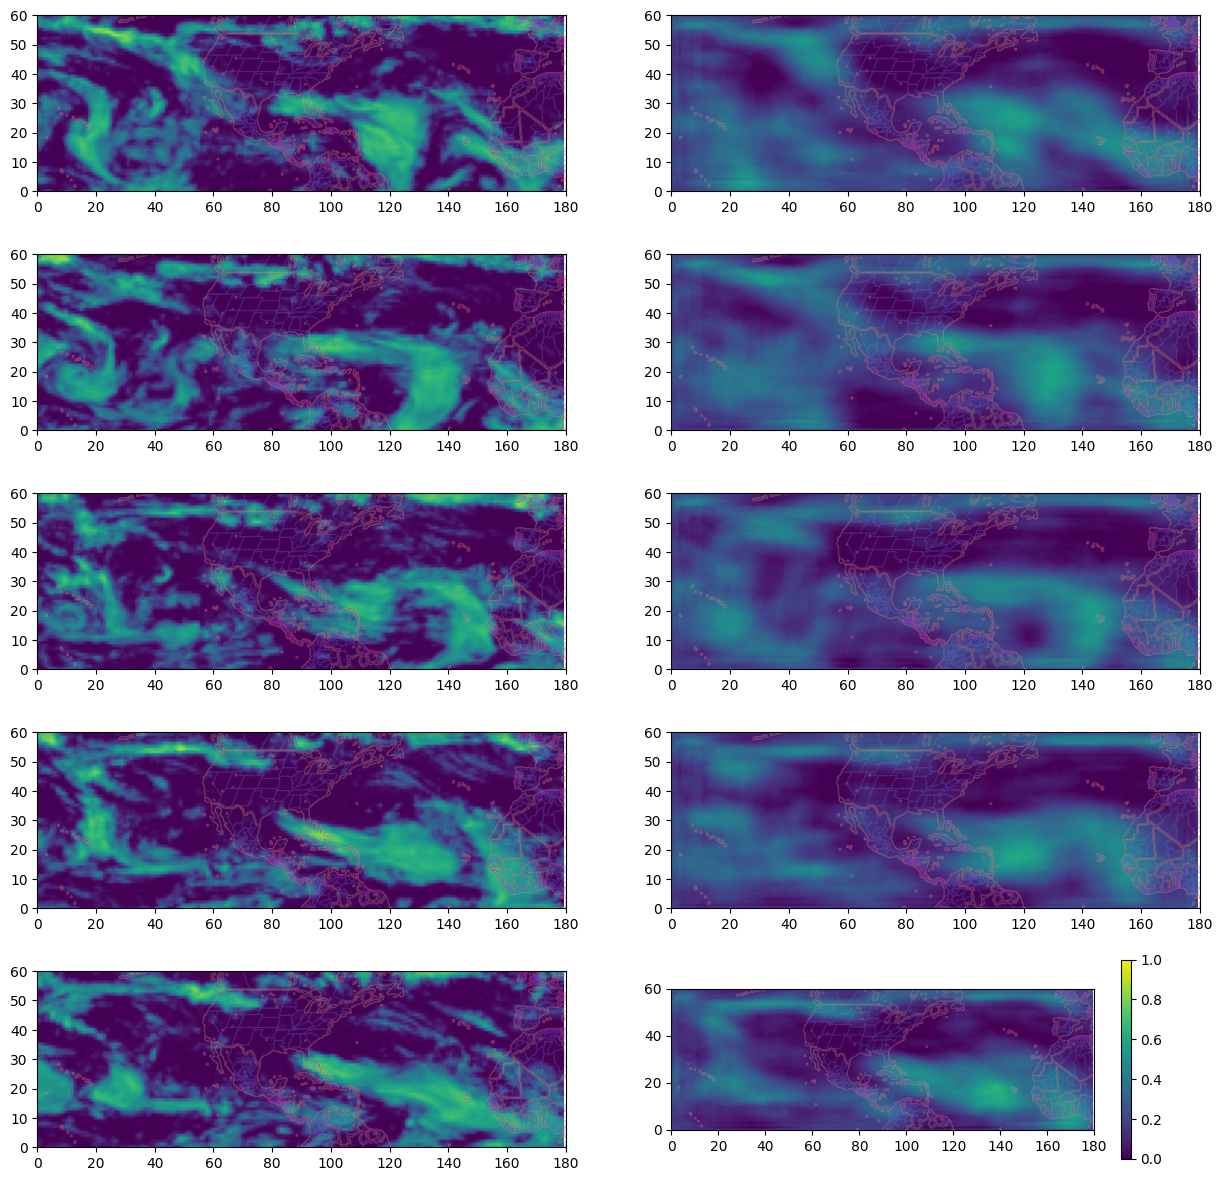

In [11]:
best_model = grid.load_best(0)
print(summary(best_model))

N_DAYS = 5
COLS = 2
IMAGE_SIZE = (60, 180)

bmap = plt.imread(get_border_map())

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(15, 3*N_DAYS))
#for ax in axs.flatten():
#    ax.axis('off')

best_model.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(best_model.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    y_shape = y.shape
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y, vmin=0, vmax=1)
    plt.imshow(bmap, extent=[0, y_shape[1], 0, y_shape[0]])

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred, vmin=0, vmax=1)
    plt.imshow(bmap, extent=[0, y_shape[1], 0, y_shape[0]])

plt.colorbar();

## More training for best configuration
### Above is only a proof of concept for machinery - not yet worth retraining

In [ ]:
# Data constants
DEV_N_IMAGES = 2_000
TRAIN_FRAC = 0.95
VAL_FRAC = 0.05
SEQ_LEN = 5

# Model
dev_image_files = image_files[:DEV_N_IMAGES]
dev_crnn = CRNN(
    in_channels=1,
    hidden_channels=2,
    kernal_size_=3,
    padding_=1,
    train_files=dev_image_files[:int(TRAIN_FRAC * DEV_N_IMAGES)]
)
model_name = 'dev_crnn_v0'
crit = nn.MSELoss()
optim = torch.optim.Adam(dev_crnn.parameters())

# Training constants
BATCH_SIZE = 64
MAX_EPOCHS = 50
MIN_IMPROV = 0.001
MAX_ITER_IMPROV = 50

train_loss, val_loss = train(
    model = dev_crnn,
    model_name = model_name,
    criterion = crit,
    optimizer = optim,
    files_list = dev_image_files,
    train_frac = TRAIN_FRAC,
    val_frac = VAL_FRAC,
    seq_len = SEQ_LEN,
    batch_size = BATCH_SIZE,
    max_epochs = MAX_EPOCHS,
    val_level = 'batch',
    early_stopping = True,
    min_improv = MIN_IMPROV,
    max_iter_improv = MAX_ITER_IMPROV,
    shuffle = True,
    log_level = 1,
    save_model = True
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

In [ ]:
N_DAYS = 5
COLS = 2
IMAGE_SIZE = (60, 180)

bmap = plt.imread(get_border_map())

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(15, 3*N_DAYS))

dev_crnn.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(dev_crnn.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    y_shape = y.shape
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y, vmin=0, vmax=1)
    plt.imshow(bmap, extent=[0, y_shape[1], 0, y_shape[0]])

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred, vmin=0, vmax=1)
    plt.imshow(bmap, extent=[0, y_shape[1], 0, y_shape[0]])

plt.colorbar();